## Clustering Nodes

The goal of semantic chunking is to ensure each chunk has as much semantically independent information as possible. How do we design an algorithm to achieve this goal?


#### Constraints:
- Node.tokens < max_tokens
- Node.tokens > min_tokens


#### Hierchical Clustering

This method builds a tree of clusters and is useful if you want a hierarchy of topics or themes. You can cut the tree at a certain level to obtain a desired number of chunks. This tree of clusters can be represented as a dendrogram.

In [4]:
!wget https://sergey-filimonov.nyc3.digitaloceanspaces.com/open-parse/sample-docs/lyft_2021-first-20-pages.pdf -O ../sample-docs/lyft-10k.pdf

--2024-04-14 13:24:48--  https://sergey-filimonov.nyc3.digitaloceanspaces.com/open-parse/sample-docs/lyft_2021-first-20-pages.pdf
Resolving sergey-filimonov.nyc3.digitaloceanspaces.com (sergey-filimonov.nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to sergey-filimonov.nyc3.digitaloceanspaces.com (sergey-filimonov.nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 379188 (370K) [application/pdf]
Saving to: ‘../sample-docs/lyft-10k.pdf’

../sample-docs/lyft 100%[===================>] 370.30K  1.89MB/s    in 0.2s    

2024-04-14 13:24:48 (1.89 MB/s) - ‘../sample-docs/lyft-10k.pdf’ saved [379188/379188]



In [13]:
import os
import sys
from importlib import reload

sys.path.append("../..")

from openparse import Pdf, processing, embeddings
from pathlib import Path
from openparse.processing import basic_transforms
from openparse import DocumentParser


class IngestionPipeline(processing.IngestionPipeline):
    """
    A basic pipeline for ingesting and processing Nodes. This is just to clean up minor issues in the PDFs.
    """

    def __init__(self):
        self.transformations = [
            basic_transforms.RemoveTextInsideTables(),
            basic_transforms.RemoveFullPageStubs(max_area_pct=0.35),
            basic_transforms.CombineNodesSpatially(
                x_error_margin=10,
                y_error_margin=2,
                criteria="both_small",
            ),
            basic_transforms.CombineHeadingsWithClosestText(),
            basic_transforms.CombineBullets(),
            basic_transforms.RemoveMetadataElements(),
            basic_transforms.RemoveRepeatedElements(threshold=2),
            basic_transforms.RemoveNodesBelowNTokens(min_tokens=10),
            basic_transforms.CombineBullets(),
        ]


pdf_path = Path("../sample-docs/lyft-10k.pdf")
doc = Pdf(pdf_path)
embedding_client = embeddings.OpenAIEmbedding(api_key=os.environ["OPEN_AI_KEY"])
parser = DocumentParser(
    processing_pipeline=IngestionPipeline(),
)
nodes = parser.parse(pdf_path).nodes

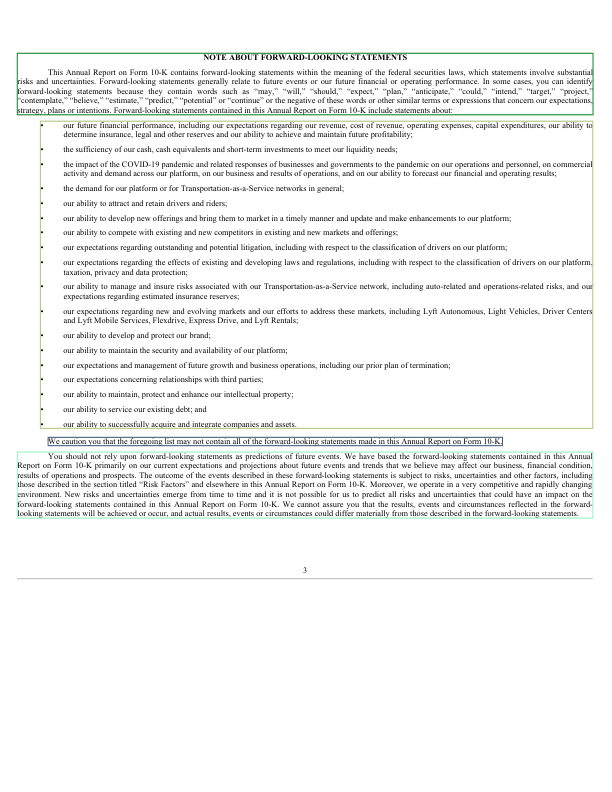

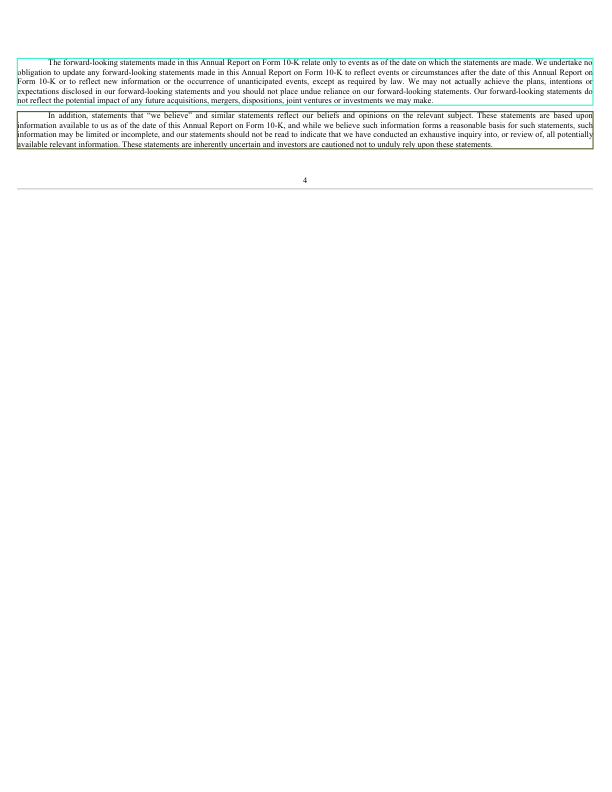

In [12]:
doc.display_with_bboxes(nodes, page_nums=list(range(2, 4)))

/Users/sergey/.pyenv/versions/3.10.4/envs/open-parse-notebooks/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


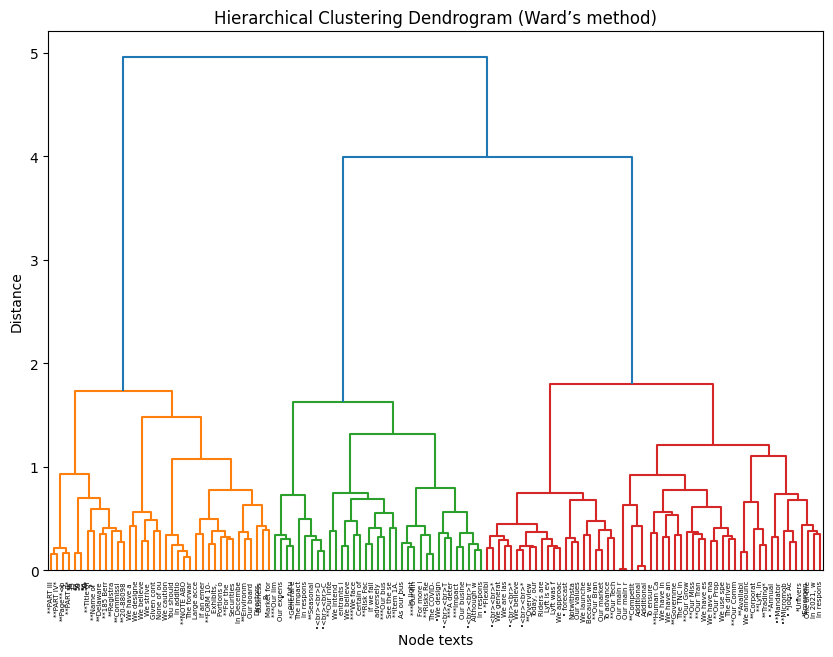

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram


embeddings = embedding_client.get_text_embedding_batch([node.text for node in nodes])


n = len(embeddings)
distance_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i + 1, n):  # The matrix is symmetric
        similarity = embedding_client.similarity(embeddings[i], embeddings[j])
        distance = 1 - similarity
        distance_matrix[i, j] = distance_matrix[j, i] = distance


# Use Ward's method
linkage_matrix = ward(distance_matrix)

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=[node.text[0:10] for node in nodes])
plt.title("Hierarchical Clustering Dendrogram (Ward's method)")
plt.xlabel("Node texts")
plt.ylabel("Distance")
plt.show()

## Let's try visualizing the clusters

We do constrain clusters to sequential nodes. This is an interesting idea to explore, because we could dynamically expand the context window based on the complexity of the question.

#### Need in the haystack:
- "Tell me about lawsuits lyft is dealing with regarding driver classification?"

#### Broad:
- "Tell me about the challenges lyft will face in the next 5 years?"


/Users/sergey/.pyenv/versions/3.10.4/envs/open-parse-notebooks/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


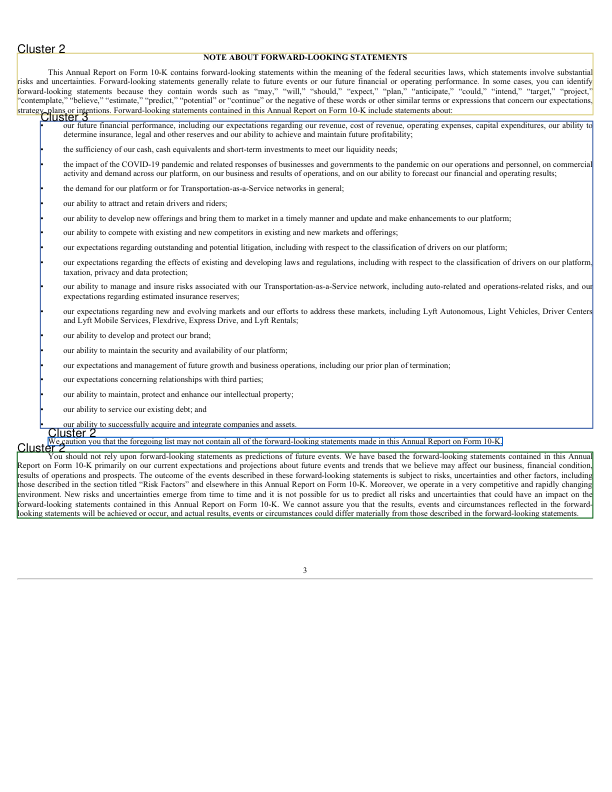

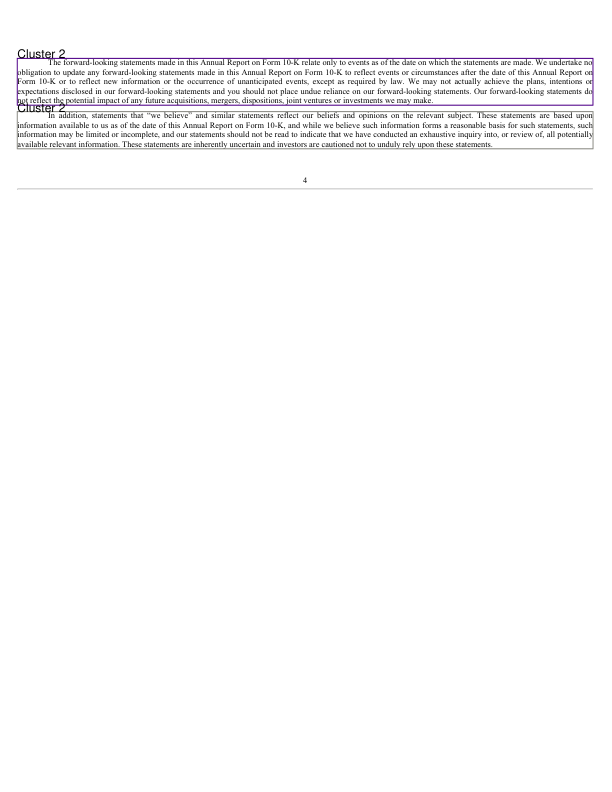

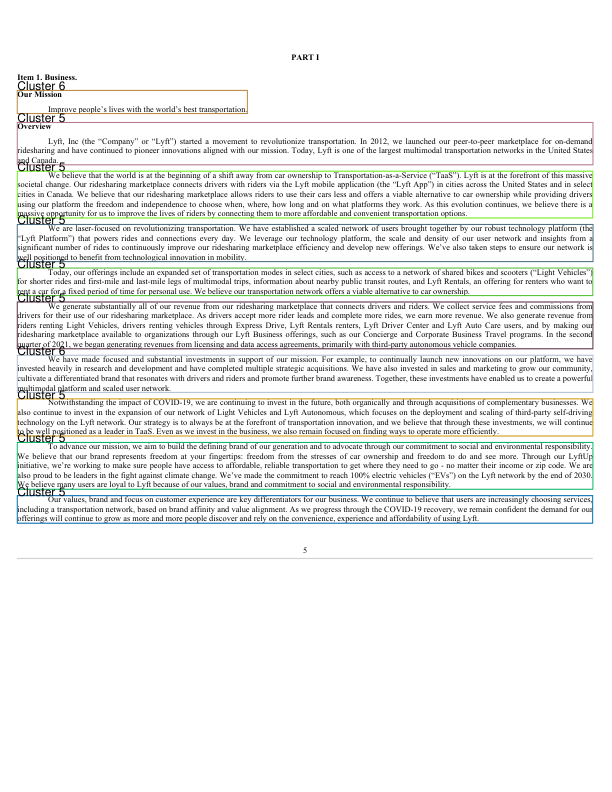

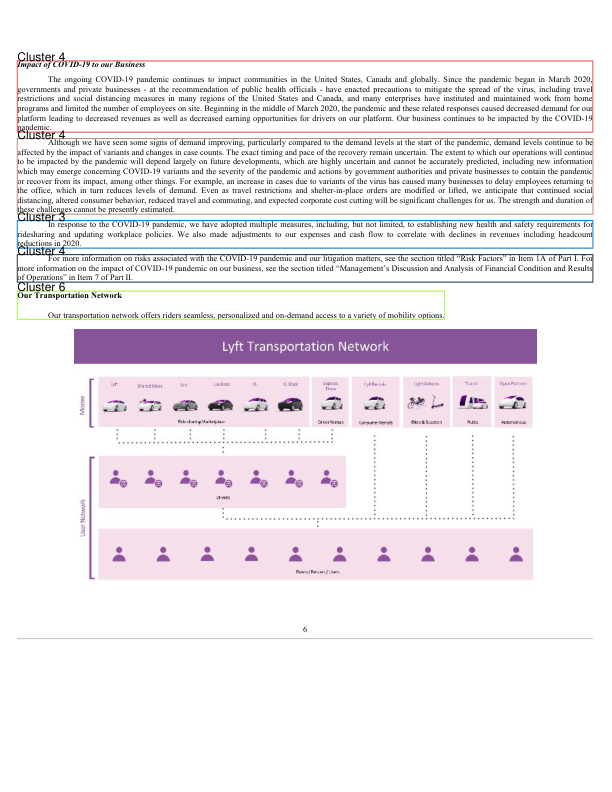

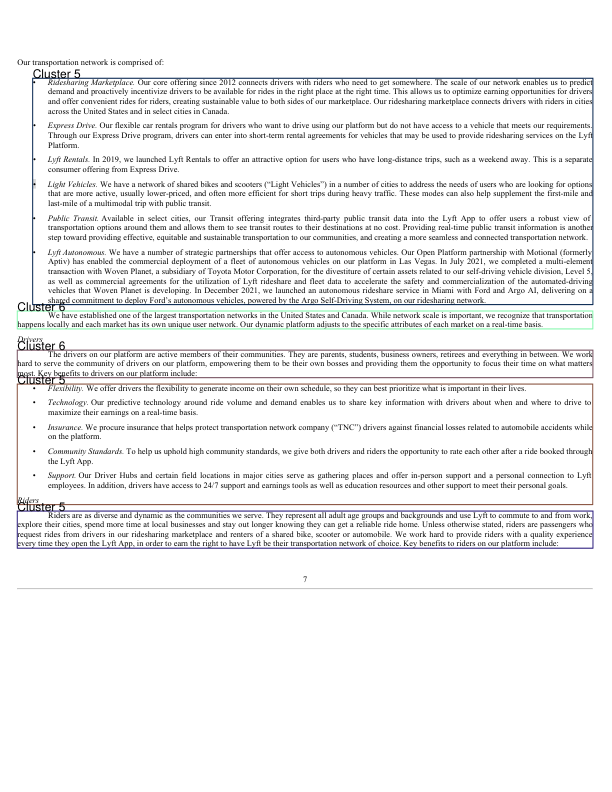

In [16]:
from scipy.cluster.hierarchy import fcluster

# Perform hierarchical clustering
linkage_matrix = ward(distance_matrix)

# Define a cutoff to determine clusters
max_dist = 1.5  # Adjust based on dendrogram analysis
clusters = fcluster(linkage_matrix, max_dist, criterion="distance")

# Assign cluster index to each node
annotations = [f"Cluster {cluster}" for cluster in clusters]

doc.display_with_bboxes(nodes, page_nums=list(range(2, 7)), annotations=annotations)